In [19]:
import os
import re
import sys
import glob
import warnings
import palettable
import numpy as np
import scipy.stats as stats
from astropy.io import fits
from scipy.stats import iqr
from tempfile import mkdtemp
from scipy.stats import skew
from astropy.time import Time
from astropy.table import Table
from astropy import visualization as vs
from sfft.utils.pyAstroMatic.PYSEx import PY_SEx
from sfft.utils.SkyLevelEstimator import SkyLevel_Estimator
from sfft.utils.StampGenerator import Stamp_Generator

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib widget

plt.rcParams.update({
   "text.usetex": True,
   "font.family": "sans-serif",
   "font.sans-serif": ["Helvetica"]})

graycmap = plt.cm.get_cmap('gray')
igraycmap = graycmap.reversed()
cmap_thermal = palettable.cmocean.sequential.Thermal_13.mpl_colormap

MAINDIR = '/run/mount/nas/Public/Thomas/RMSIM/ship2pitsn'   # FIXME
output_dir = MAINDIR + '/output'
refname = 'Roman_WAS_simple_model_H158_9758_15'
sciname = 'Roman_WAS_simple_model_H158_11832_15'

FITS_lREF = output_dir + '/%s.sciE.skysub.stamp.fits' %refname # use stamp
FITS_lSCI = output_dir + '/%s.sciE.skysub.resamp.stamp.fits' %sciname # use stamp
FITS_REF = output_dir + '/%s.sciE.skysub.crossConvd.stamp.fits' %refname # use stamp
FITS_SCI = output_dir + '/%s.sciE.skysub.resamp.crossConvd.stamp.fits' %sciname # use stamp
#FITS_PSF_REF = output_dir + '/%s.centPSF.fits' %refname
#FITS_PSF_ReSCI = output_dir + '/%s.resamp.centPSF.fits' %sciname # rotated/resampled

FITS_DIFF = FITS_SCI[:-5] + '.polysfftdiff.fits'
FITS_DCDIFF = FITS_DIFF[:-5] + '.DeCorrelated.fits'
FITS_DCDIFF_SNR = FITS_DIFF[:-5] + '.DeCorrelated.SNR.fits'

PixA_lREF = fits.getdata(FITS_lREF, ext=0).T
PixA_lSCI = fits.getdata(FITS_lSCI, ext=0).T
PixA_REF = fits.getdata(FITS_REF, ext=0).T
PixA_SCI = fits.getdata(FITS_SCI, ext=0).T
#PixA_PSF_REF = fits.getdata(FITS_PSF_REF, ext=0).T
#PixA_PSF_SCI = fits.getdata(FITS_PSF_ReSCI, ext=0).T  # rotated/resampled

PixA_DIFF = fits.getdata(FITS_DIFF, ext=0).T
PixA_DCDIFF = fits.getdata(FITS_DCDIFF, ext=0).T
PixA_DCDIFF_SNR = fits.getdata(FITS_DCDIFF_SNR, ext=0).T


In [11]:
# * define background region using NoiseChisel detection (0/1/NaN)
# * define N-sigma detection region relative to a global background level

def getBKG(FITS_obj):
    SExParam = ['X_IMAGE', 'Y_IMAGE', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', \
        'FLUX_RADIUS', 'FWHM_IMAGE', 'A_IMAGE', 'B_IMAGE', 'KRON_RADIUS', 'THETA_IMAGE', 'SNR_WIN']
    BKGMASK = PY_SEx.PS(FITS_obj=FITS_REF, SExParam=SExParam, GAIN_KEY='GAIN', SATUR_KEY='SATURATE', \
        BACK_TYPE='MANUAL', BACK_VALUE=0.0, BACK_SIZE=64, BACK_FILTERSIZE=3, DETECT_THRESH=1.2, \
        DETECT_MINAREA=5, DETECT_MAXAREA=0, DEBLEND_MINCONT=0.001, BACKPHOTO_TYPE='LOCAL', \
        CHECKIMAGE_TYPE='SEGMENTATION', AddRD=True, ONLY_FLAGS=None, XBoundary=0.0, YBoundary=0.0, \
        MDIR=None, VERBOSE_LEVEL=1)[1][0] == 0
    return BKGMASK

def getDET(FITS_obj, NSIG):
    PixA_obj = fits.getdata(FITS_obj, ext=0).T
    bkgsig = SkyLevel_Estimator.SLE(PixA_obj=PixA_obj)[1]
    DETMASK = PixA_obj > NSIG * bkgsig
    return DETMASK

BOUNDARY = np.ones(PixA_lSCI.shape, dtype=bool)
BOUNDARY[30:-30, 30:-30] = False

BKGMASK_lSCI = getBKG(FITS_lSCI)
BKGMASK_lREF = getBKG(FITS_lREF)
BKGMASK = np.logical_and.reduce((BKGMASK_lSCI, BKGMASK_lREF, ~BOUNDARY))

DETMASKA_lSCI = getDET(FITS_lSCI, 5.0)
DETMASKA_lREF = getDET(FITS_lREF, 5.0)
DETMASKA = np.logical_and.reduce((DETMASKA_lSCI, DETMASKA_lREF, ~BOUNDARY))

DETMASKB_lSCI = getDET(FITS_lSCI, 100.0)
DETMASKB_lREF = getDET(FITS_lREF, 100.0)
DETMASKB = np.logical_and.reduce((DETMASKB_lSCI, DETMASKB_lREF, ~BOUNDARY))

# * statistics of DCDSNR on different regions
DCDSNR_BKG = PixA_DCDIFF_SNR[BKGMASK].flatten()
DCDSNR_DETA = PixA_DCDIFF_SNR[DETMASKA].flatten()
DCDSNR_DETB = PixA_DCDIFF_SNR[DETMASKB].flatten()

def getSNRSTATS(DCDSNR):
    Q1 = np.percentile(DCDSNR, 25)
    Q3 = np.percentile(DCDSNR, 75)
    IQR = Q3 - Q1
    MINI = Q1 - 1.5*IQR
    MAXI = Q3 + 1.5*IQR
    OutlierMask = np.logical_or(
        DCDSNR < MINI,
        DCDSNR > MAXI
    )
    DCDSNR_MEAN = np.mean(DCDSNR)
    DCDSNR_STD = IQR / 1.349
    DCDSNR_SKEW = skew(DCDSNR[~OutlierMask])
    return DCDSNR_MEAN, DCDSNR_STD, DCDSNR_SKEW

DCDSNR_BKG_MEAN, DCDSNR_BKG_STD, DCDSNR_BKG_SKEW = getSNRSTATS(DCDSNR_BKG)
DCDSNR_DETA_MEAN, DCDSNR_DETA_STD, DCDSNR_DETA_SKEW = getSNRSTATS(DCDSNR_DETA)
DCDSNR_DETB_MEAN, DCDSNR_DETB_STD, DCDSNR_DETB_SKEW = getSNRSTATS(DCDSNR_DETB)



MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: Run Python Wrapper of SExtractor!
MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: SExtractor uses GAIN = [1.0] from keyword [GAIN]!
MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: SExtractor uses SATURATION = [120000.0] from keyword [SATURATE]!
MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: SExtractor found [889] sources!
MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: PYSEx output catalog contains [889] sources!

MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: Run Python Wrapper of SExtractor!
MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE.skysub.crossConvd.stamp.fits]: SExtractor uses GAIN = [1.0] from keyword [GAIN]!
MeLOn CheckPoint [Roman_WAS_simple_model_H158_9758_15.sciE

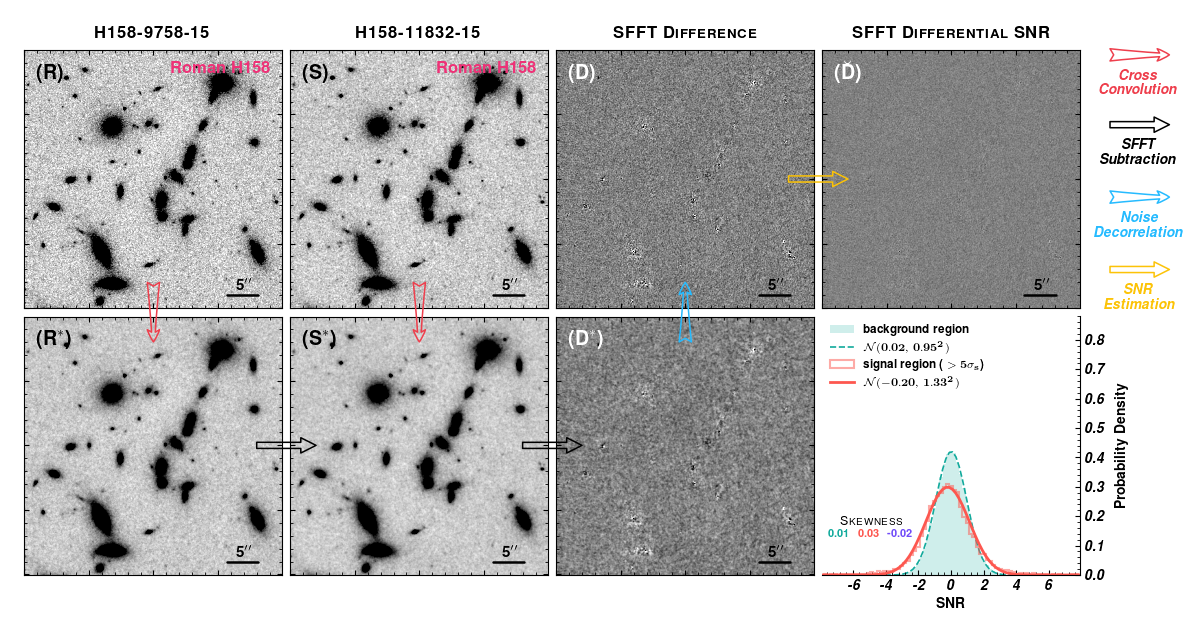

In [37]:
fig = plt.figure(figsize=((8.6+0.4)*4/3, 6.25))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig.subplots_adjust(hspace=0.03, wspace=0.03, \
    left=0.02, right=0.9, bottom=0.08, top=0.92)

PIXSCAL = 0.103
ra_sn, dec_sn = 9.2467827, -43.9819722 #9.2480019, -43.9786931
boxsize_bkg = (35, 35)
boxsize_lview = (800, 800)
boxsize_sview = (400, 400)
boxsize_sn = (5, 5)

gs = gridspec.GridSpec(2, 4)
axU1 = plt.subplot(gs[0, 0])
axU2 = plt.subplot(gs[0, 1])
axU3 = plt.subplot(gs[0, 2])
axU4 = plt.subplot(gs[0, 3])

axL1 = plt.subplot(gs[1, 0])
axL2 = plt.subplot(gs[1, 1])
axL3 = plt.subplot(gs[1, 2])
axL4 = plt.subplot(gs[1, 3])

def painter(FITS_obj, ax, vmin, vmax, cmap=igraycmap, center_cross=False, label_target=False, \
    panel_label=None, panel_color='black', corner_label=None, title_label=None):

    COORD = np.array([[ra_sn, dec_sn]])
    STAMP_NX, STAMP_NY = boxsize_sview
    cutout = Stamp_Generator.SG(FITS_obj=FITS_obj, EXTINDEX=0, STAMP_IMGSIZE=(STAMP_NX, STAMP_NY), \
        COORD=COORD, COORD_TYPE='WORLD', FILL_VALUE=np.nan, VERBOSE_LEVEL=1)[0]

    # draw image
    ax.imshow(cutout.T, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)

    # add ruler
    ax.axhline(5*4, xmin=78.5*4/STAMP_NX, xmax=(78.5*4+5/PIXSCAL)/STAMP_NY, \
        linestyle='-', linewidth=1.8, color='black', solid_capstyle='round')
    ax.annotate(r'{$\textbf{5}^{\prime\prime}$}', xy=(82.*4, 7*4), fontsize=11., color='black')

    # add panel label
    if panel_label is not None:
        #ax.annotate(r'\textbf{%s}' %panel_label, xy=(4.2, 90.), fontsize=12.5, color='black')
        ax.annotate(panel_label, xy=(4.5*4, 88.8*4), fontsize=14.2, color=panel_color)

    # add corner label
    if corner_label is not None:
        ax.annotate(r'\textbf{%s}' %corner_label, xy=(57*4, 91.*4), fontsize=12.0, color='#EE3277')
    
    # add target label
    if label_target:
        ax.annotate(r'\textbf{AT 2022acew}', xy=(57., 57.), fontsize=10.0, color='white')

    # add title
    if title_label is not None:
        ax.set_title(r'\textbf{\textsc{%s}}' %title_label, fontsize=12.0, color='black', pad=9)

    # add rectangle
    ax.add_patch(patches.Rectangle((193-50, 548-50), 100, 100, \
        edgecolor='#FF214A', linestyle='--', linewidth=0.5, facecolor='none'))

    ax.tick_params(which='both', top=True, bottom=True, left=True, right=True, \
        labelleft=False, labelright=False, labelbottom=False, labeltop=False)

    if center_cross:
        _x, _y = STAMP_NX/2. - 0.3, STAMP_NY/2. + 0.3
        ax.axhline(_y, xmin=(_x+5)/STAMP_NX, xmax=(_x+11)/STAMP_NY, color='white', linewidth=1.4, solid_capstyle='round')
        ax.axhline(_y, xmin=(_x-11)/STAMP_NX, xmax=(_x-5)/STAMP_NY, color='white', linewidth=1.4, solid_capstyle='round')
        ax.axvline(_x, ymin=(_y+5)/STAMP_NX, ymax=(_y+11)/STAMP_NY, color='white', linewidth=1.4, solid_capstyle='round')
        ax.axvline(_x, ymin=(_y-11)/STAMP_NX, ymax=(_y-5)/STAMP_NY, color='white', linewidth=1.4, solid_capstyle='round')

    MajorLocator = 100
    MinorLocator = 20

    ax.xaxis.set_major_locator(MultipleLocator(MajorLocator))
    ax.xaxis.set_minor_locator(MultipleLocator(MinorLocator))
    ax.yaxis.set_major_locator(MultipleLocator(MajorLocator))
    ax.yaxis.set_minor_locator(MultipleLocator(MinorLocator))

    ax.set_xlim(-0.5, STAMP_NX-0.5)
    ax.set_ylim(-0.5, STAMP_NY-0.5)

    return None

# draw images
pl = r'$\textbf{(}\mathbf{\textbf{\textsc{R}}}\textbf{)}$'
painter(FITS_obj=FITS_lREF, ax=axU1, vmin=-16, vmax=56, center_cross=False, \
    panel_label=pl, panel_color='black', corner_label='Roman H158', title_label='H158-9758-15')

pl = r'$\textbf{(}\mathbf{\textbf{\textsc{S}}}\textbf{)}$'
painter(FITS_obj=FITS_lSCI, ax=axU2, vmin=-16, vmax=56, center_cross=False, \
    panel_label=pl, panel_color='black', \
    corner_label='Roman H158', title_label='H158-11832-15')

pl = r'$\textbf{(}\mathbf{\textbf{\textsc{D}}}\textbf{)}$'
painter(FITS_obj=FITS_DCDIFF, ax=axU3, vmin=-60, vmax=60, center_cross=False, \
    panel_label=pl, panel_color='white', title_label='SFFT Difference')

pl = r'$\textbf{(}\mathbf{\breve{\textbf{\textsc{D}}}}\textbf{)}$'
painter(FITS_obj=FITS_DCDIFF_SNR, ax=axU4, vmin=-7.2, vmax=7.2, \
    panel_label=pl, panel_color='white', \
    center_cross=False, label_target=False, title_label='SFFT Differential SNR')

pl = r'$\textbf{(}\mathbf{\textbf{\textsc{R}}^{*}}\textbf{)}$'
painter(FITS_obj=FITS_REF, ax=axL1, vmin=-16, vmax=56, \
    panel_label=pl, panel_color='black', center_cross=False)

pl = r'$\textbf{(}\mathbf{\textbf{\textsc{S}}^{*}}\textbf{)}$'
painter(FITS_obj=FITS_SCI, ax=axL2, vmin=-16, vmax=56, \
    panel_label=pl, panel_color='black', center_cross=False)

pl = r'$\textbf{(}\mathbf{\textbf{\textsc{D}}^{*}}\textbf{)}$'
painter(FITS_obj=FITS_DIFF, ax=axL3, vmin=-30, vmax=30, \
    panel_label=pl, panel_color='white', center_cross=False)

# draw histograms
bins = np.linspace(-10., 10., 100)
axL4.hist(DCDSNR_BKG[np.abs(DCDSNR_BKG) < 10.0], bins=bins, density=True, \
    color='#12aa9c', linewidth=1.3, label=r'\textbf{background region}', alpha=0.2, zorder=1) #00A5C9

axL4.plot(bins, stats.norm.pdf(bins, DCDSNR_BKG_MEAN, DCDSNR_BKG_STD), \
    linestyle='--', color='#12aa9c', linewidth=1.2, label=r'${\bf \mathcal{N}(%.2f,\,%.2f^{2}})$' \
    %(DCDSNR_BKG_MEAN, DCDSNR_BKG_STD), alpha=1, zorder=1) #00A5C9

axL4.hist(DCDSNR_DETA[np.abs(DCDSNR_DETA) < 10.0], bins=bins, density=True, \
    color='#FD574F', linewidth=1.5, histtype='step', \
    label=r'\textbf{signal region (${\bf > 5\sigma_s}$)}', alpha=0.5, zorder=2)

axL4.plot(bins, stats.norm.pdf(bins, DCDSNR_DETA_MEAN, DCDSNR_DETA_STD), \
    linestyle='-', color='#FD574F', linewidth=2., label=r'${\bf \mathcal{N}(%.2f,\,%.2f^{2}})$' \
    %(DCDSNR_DETA_MEAN, DCDSNR_DETA_STD), zorder=2)

#axL4.hist(DCDSNR_DETB[np.abs(DCDSNR_DETB) < 10.0], bins=bins, density=True, \
#    color='#714CF9', linewidth=1.3, histtype='step', \
#    label=r'\textbf{signal region (${\bf > 100\sigma_s}$)}', alpha=0.5, zorder=2)

#axL4.plot(bins, stats.norm.pdf(bins, DCDSNR_DETB_MEAN, DCDSNR_DETB_STD), \
#    linestyle='-', color='#714CF9', linewidth=2., label=r'${\bf \mathcal{N}(%.2f,\,%.2f^{2}})$' \
#    %(DCDSNR_DETB_MEAN, DCDSNR_DETB_STD), zorder=2)

#for snr in DCDSNR_SN[DCDSNR_SN > 5.0]:
#    axL4.axvline(x=snr, ymin=0, ymax=0.05, color='black', linewidth=1.5)
#axL4.annotate(r'\textbf{AT 2022acew}', xy=(2.75, 0.06), fontsize=9., color='black')

axL4.annotate(r'\textsc{Skewness}', xy=(-6.8, 0.12+0.05), fontsize=9., color='black')
axL4.annotate(r'\textbf{%.2f}' %DCDSNR_BKG_SKEW, xy=(-7.5, 0.08+0.05), fontsize=8., color='#12aa9c') #00A5C9
axL4.annotate(r'\textbf{%.2f}' %DCDSNR_DETA_SKEW, xy=(-5.7, 0.08+0.05), fontsize=8., color='#FD574F')
axL4.annotate(r'\textbf{%.2f}' %DCDSNR_DETB_SKEW, xy=(-3.9, 0.08+0.05), fontsize=8., color='#714CF9')

axL4.legend(loc=2, frameon=False, fontsize=8.5, borderpad=0.2)
axL4.tick_params(which='both', top=False, bottom=True, left=False, right=True, \
    labelleft=False, labelright=True, labelbottom=True, labeltop=False)

axL4.spines['top'].set_visible(False)
axL4.spines['right'].set_visible(True)
axL4.spines['bottom'].set_visible(True)
axL4.spines['left'].set_visible(False)

axL4.xaxis.set_major_locator(MultipleLocator(2))
axL4.xaxis.set_minor_locator(MultipleLocator(0.4))
axL4.yaxis.set_major_locator(MultipleLocator(0.1))
axL4.yaxis.set_minor_locator(MultipleLocator(0.02))

axL4.xaxis.set_ticks(axL4.get_xticks())
axL4.set_xticklabels([r'\textit{\textbf{%d}}' %int(t) for t in axL4.get_xticks()])
plt.setp(axL4.get_xticklabels(), fontsize=10)

axL4.yaxis.set_ticks(np.arange(0, 1., 0.1)) #axL4.get_yticks())
axL4.set_yticklabels([r'\textit{\textbf{%.1f}}' %t for t in axL4.get_yticks()])
plt.setp(axL4.get_yticklabels(), fontsize=10)

axL4.set_xlabel(r'\textbf{SNR}')
axL4.set_ylabel(r'\textbf{Probability Density', labelpad=8)
axL4.yaxis.set_label_position("right")
axL4.set_xlim(-7.9, 7.9)
#axL4.set_ylim(0, 22001)
axL4.set_ylim(0, 0.88)

"""
# add PSF
caxU1 = inset_axes(axU1, width="100%", height="100%", bbox_to_anchor=(0/100, 0/100, 25/100, 25/100), \
    loc='lower left', borderpad=0, bbox_transform=axU1.transAxes)
caxU1.imshow(PixA_PSF_REF[250-31:250+31, 250-31:250+31].T, origin='lower', cmap=cmap_thermal, vmin=0., vmax=0.0003)

caxU2 = inset_axes(axU2, width="100%", height="100%", bbox_to_anchor=(0/100, 0/100, 25/100, 25/100), \
    loc='lower left', borderpad=0, bbox_transform=axU2.transAxes)
caxU2.imshow(PixA_PSF_SCI[250-31:250+31, 250-31:250+31].T, origin='lower', cmap=cmap_thermal, vmin=0., vmax=0.0003)

caxU3 = inset_axes(axU3, width="100%", height="100%", bbox_to_anchor=(0/100, 0/100, 25/100, 25/100), \
    loc='lower left', borderpad=0, bbox_transform=axU3.transAxes)
#caxU3.imshow(PixA_dcPSF_SNTILE[62:-62, 62:-62].T, origin='lower', cmap=cmap_thermal, vmin=0., vmax=0.0004)

caxL1 = inset_axes(axL1, width="100%", height="100%", bbox_to_anchor=(0/100, 0/100, 25/100, 25/100), \
    loc='lower left', borderpad=0, bbox_transform=axL1.transAxes)
#caxL1.imshow(PixA_centPSF_SCI[62:-62, 62:-62].T, origin='lower', cmap=cmap_thermal, vmin=0., vmax=0.0004)

for cax in [caxU1, caxU2, caxU3, caxL1]:
    cax.tick_params(which='both', top=True, bottom=True, left=True, right=True, \
        labelleft=False, labelright=False, labelbottom=False, labeltop=False)
    #cax.axhline(6, xmin=42/81, xmax=(42+1.0/PIXSCAL)/81, color='white', linewidth=1.0, solid_capstyle='round')
    #cax.annotate(r'{$\textbf{1}^{\prime\prime}$}', xy=(56, 11), fontsize=9, color='white')
    cax.set_xlim(-0.5, 63-0.5)
    cax.set_ylim(-0.5, 63-0.5)
"""

def add_arrow(xyA, xyB, fig, axA, axB, edgecolor='black', arrowstyle='fancy'):
        
    transFigure = fig.transFigure.inverted()
    coord1 = transFigure.transform(axA.transData.transform(xyA))
    coord2 = transFigure.transform(axB.transData.transform(xyB))

    arrow = patches.FancyArrowPatch(
        coord1,  # posA
        coord2,  # posB
        shrinkA=0,  # so tail is exactly on posA (default shrink is 2)
        shrinkB=0,  # so head is exactly on posB (default shrink is 2)
        transform=fig.transFigure,
        edgecolor=edgecolor,
        arrowstyle=arrowstyle,  # "normal" arrow
        mutation_scale=22,  # controls arrow head size
        linewidth=1.1,
        facecolor="none",
    )
    fig.patches.append(arrow)

    return None

# From U1 to L1, U2 to L2, for cross convolutions 
add_arrow([50*4, 10*4], [50*4, 90*4], fig, axU1, axL1, edgecolor='#ee3f4d', arrowstyle='fancy')
add_arrow([50*4, 10*4], [50*4, 90*4], fig, axU2, axL2, edgecolor='#ee3f4d', arrowstyle='fancy')

# From L1 to L2 to L3, for SFFT subtraction
add_arrow([90*4, 50*4], [10*4, 50*4], fig, axL1, axL2, edgecolor='black', arrowstyle='simple')
add_arrow([90*4, 50*4], [10*4, 50*4], fig, axL2, axL3, edgecolor='black', arrowstyle='simple')

# From L3 to U3, for decorrelation
add_arrow([50*4, 90*4], [50*4, 10*4], fig, axL3, axU3, edgecolor='#26BBFF', arrowstyle='fancy')

# From U4 to L4, for SNR estimation
add_arrow([90*4, 50*4], [10*4, 50*4], fig, axU3, axU4, edgecolor='#fcc307', arrowstyle='simple') #fcc307

# legend for arrows
add_arrow([111.5*4, 98*4], [111.5*4+23*4, 98*4], fig, axU4, axU4, edgecolor='#ee3f4d', arrowstyle='fancy')
_text = r'\textbf{\textit{Cross}}' + '\n' + r'\textbf{\textit{Convolution}}'
axU4.annotate(_text, xy=(122.7*4, 98*4-11*4), fontsize=10.0, color='#ee3f4d', \
    annotation_clip=False, verticalalignment='center', horizontalalignment='center') # rotation=90

add_arrow([111.5*4, 71*4], [111.5*4+23*4, 71*4], fig, axU4, axU4, edgecolor='black', arrowstyle='simple')
_text = r'\textbf{\textit{SFFT}}' + '\n' + r'\textbf{\textit{Subtraction}}'
axU4.annotate(_text, xy=(122.7*4, 71*4-11*4), fontsize=10.0, color='black', \
    annotation_clip=False, verticalalignment='center', horizontalalignment='center') # rotation=90

add_arrow([111.5*4, 43*4], [111.5*4+23*4, 43*4], fig, axU4, axU4, edgecolor='#26BBFF', arrowstyle='fancy')
_text = r'\textbf{\textit{Noise}}' + '\n' + r'\textbf{\textit{Decorrelation}}'
axU4.annotate(_text, xy=(122.7*4, 43*4-11*4), fontsize=10.0, color='#26BBFF', \
    annotation_clip=False, verticalalignment='center', horizontalalignment='center') # rotation=90

add_arrow([111.5*4, 15*4], [111.5*4+23*4, 15*4], fig, axU4, axU4, edgecolor='#fcc307', arrowstyle='simple')
_text = r'\textbf{\textit{SNR}}' + '\n' + r'\textbf{\textit{Estimation}}'
axU4.annotate(_text, xy=(122.7*4, 15*4-11*4), fontsize=10.0, color='#fcc307', \
    annotation_clip=False, verticalalignment='center', horizontalalignment='center') # rotation=90

#lbox = patches.FancyBboxPatch((823.5/8, -24/8), 310/8, 850/8,
#    boxstyle="round,rounding_size=1.",
#    mutation_aspect=3, edgecolor='#cfccc9', linestyle='-', 
#    linewidth=1.5, facecolor='none', clip_on=False)
#axU4.add_patch(lbox)

plt.show()

(501, 501)

In [ ]:
250